In [1]:
import numpy as np
import matplotlib.pyplot as plt

colors = ['#65C2A5', '#D4D669', '#8DA0CB', '#E78AC3']

In [32]:
def uptake(t, g, derivative=False):
    if derivative:
        if g == 0:
            return np.zeros_like(t)
        return 0.5*g*np.exp(-g*t)
    if g == 0:
        return np.zeros_like(t) + .5
    return (1-np.exp(-g*t))*.5 + .5 -.1


def ewmv(X, step, init_mean=.5, init_var=.25, return_keys='all'):
    out_dict = {}
    out_dict['diff'] = [X[0] - init_mean]
    out_dict['incr'] = [step*(out_dict['diff'][0])]
    out_dict['mean'] = [init_mean + out_dict['incr'][0]]
    out_dict['var'] = [(1-step) * (init_var + out_dict['diff'][0] * out_dict['incr'][0])]

    for i, x in enumerate(X[1:]):
        diff = x - out_dict['mean'][i]
        incr = step * diff
        mean = out_dict['mean'][i] + incr
        vari = (1-step) * (out_dict['var'][i] + diff * incr)
        out_dict['mean'].append(mean)
        out_dict['diff'].append(diff)
        out_dict['incr'].append(incr)
        out_dict['var'].append(vari)

    for k, v in out_dict.items():
        out_dict[k] = np.array(v)

    if return_keys == 'all':
        return out_dict
    else:
        return dict((k, out_dict[k]) for k in return_keys if k in out_dict)

# Visualize competence and confidence features

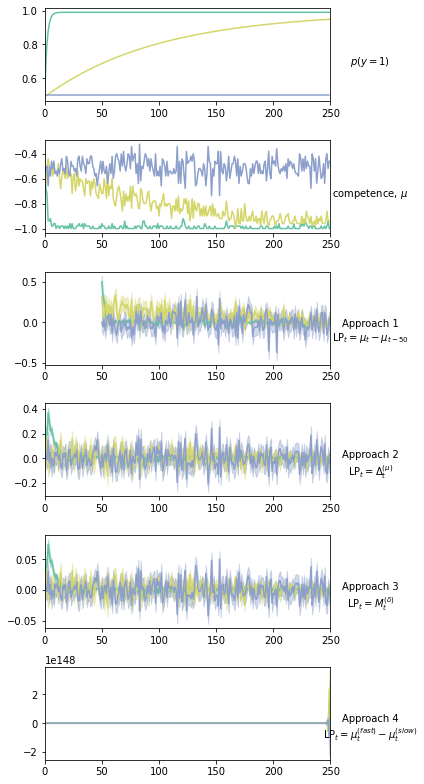

In [189]:
k = 6
N = 50
mean_or_var = 'mean'
urates = (1/2,1/100,0)
x = np.arange(250)
curves = np.stack([uptake(x, r) for r in urates])

fig, ax = plt.subplots(nrows=k, num='lp_approaches', figsize=[6, 11])
ax[0].set_ylabel(r'$p(y=1)$', rotation=0, labelpad=40, ha='right')


if mean_or_var == 'mean':
    ax[1].set_ylabel(r'competence, $\mu$', rotation=0, labelpad=40, ha='right')
    ax[2].set_ylabel('Approach 1\n'+r'LP$_t = \mu_t - \mu_{t-50}$', rotation=0, labelpad=40, ha='right')
    ax[3].set_ylabel('Approach 2\n'+r'LP$_t = \Delta^{(\mu)}_t$', rotation=0, labelpad=40, ha='right')
    ax[4].set_ylabel('Approach 3\n'+r'LP$_t = M^{(\delta)}_{t}$', rotation=0, labelpad=40, ha='right')
    ax[5].set_ylabel('Approach 4\n'+r'LP$_t = \mu^{(fast)}_t - \mu^{(slow)}_t$', rotation=0, labelpad=40, ha='right')
else:
    ax[1].set_ylabel(r'uncertainty, $\sigma$', rotation=0, labelpad=40, ha='right')
    ax[2].set_ylabel('Approach 1\n'+r'LP$_t = \sigma_t - \sigma_{t-50}$', rotation=0, labelpad=40, ha='right')
    ax[3].set_ylabel('Approach 2\n'+r'LP$_t = \Delta^{(\sigma)}_t$', rotation=0, labelpad=40, ha='right')
    ax[4].set_ylabel('Approach 3\n'+r'LP$_t = S^{(\delta)}_{t}$', rotation=0, labelpad=40, ha='right')
    ax[5].set_ylabel('Approach 4\n'+r'LP$_t = \sigma^{(fast)}_t - \sigma^{(slow)}_t$', rotation=0, labelpad=40, ha='right')


for i in range(k):
    ax[i].yaxis.set_label_position('right')

z = .99
fop, sop = z, z*.2
rnd = np.random.uniform(0, 1, [N, 3, 250])
y = (rnd < curves).astype(int)

for i in range(3):
    ax[0].plot(curves[i, :], color=colors[i])
    mu = np.stack([ewmv(yi, fop)[mean_or_var] for yi in y[:, i, :]])
    diff = np.stack([ewmv(yi, fop)['diff'] for yi in y[:, i, :]])
    mu_short = np.stack([ewmv(yi, fop*5)[mean_or_var] for yi in y[:, i, :]])

    ax[1].plot(-mu.mean(axis=0), color=colors[i])

    # Approach #1
    lp = (mu[:, 50:]-mu[:, :-50])
    lp_err = np.std(lp, axis=0)/np.sqrt(N)
    ax[2].plot(np.arange(50, 250), lp.mean(axis=0), color=colors[i])
    ax[2].fill_between(np.arange(50, 250), lp.mean(axis=0)+lp_err, lp.mean(axis=0)-lp_err, color=colors[i], alpha=.4)

    # Approach #2
    lp = np.stack([ewmv(mu_i, sop, init_mean=.5 if mean_or_var=='mean' else .25)['diff'] for mu_i in mu])
    lp_err = np.std(lp, axis=0)/np.sqrt(N)
    ax[3].plot(lp.mean(axis=0), color=colors[i])
    ax[3].fill_between(x, lp.mean(axis=0)+lp_err, lp.mean(axis=0)-lp_err, color=colors[i], alpha=.4)

    # Approach #3
    lp = np.stack([ewmv(diff_i, sop, init_mean=.0, init_var=.0 if mean_or_var=='mean' else .25)[mean_or_var] for diff_i in diff])
    lp_err = np.std(lp, axis=0)/np.sqrt(N)
    ax[4].plot(lp.mean(axis=0), color=colors[i])
    ax[4].fill_between(x, lp.mean(axis=0)+lp_err, lp.mean(axis=0)-lp_err, color=colors[i], alpha=.4)

    # Approach #4
    lp = (mu_short - mu)
    lp_err = np.std(lp, axis=0)/np.sqrt(N)
    ax[5].plot(lp.mean(axis=0), color=colors[i])
    ax[5].fill_between(x, lp.mean(axis=0)+lp_err, lp.mean(axis=0)-lp_err, color=colors[i], alpha=.4)

for axis in ax: 
    axis.set_xlim(0,250)
    
fig.tight_layout()
# fig.savefig(f'lp_approaches_{mean_or_var}.png')

29.61367993768584 64.23381290937559


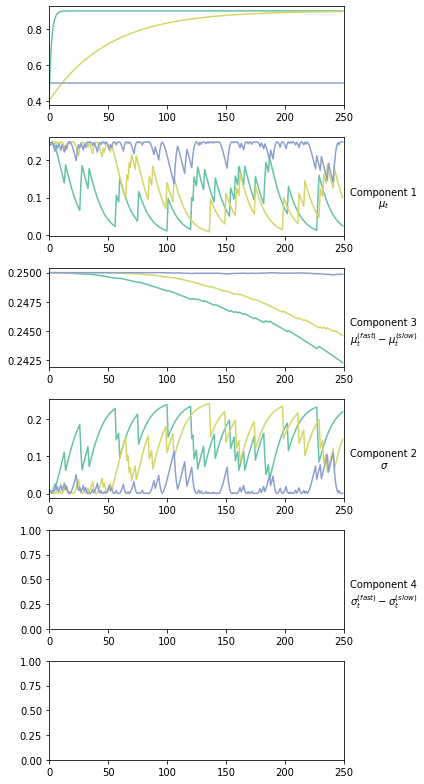

In [34]:
k = 6
N = 1
mean_or_var = 'mean'
urates = (1/2,1/50,0)
x = np.arange(250)
curves = np.stack([uptake(x, r) for r in urates])

fig, ax = plt.subplots(nrows=k, num='lp_approaches', figsize=[6, 11])

ax[1].set_ylabel('Component 1\n'+r'$\mu_t$', rotation=0, labelpad=40, ha='right')
ax[2].set_ylabel('Component 3\n'+r'$\mu^{(fast)}_t - \mu^{(slow)}_t$', rotation=0, labelpad=40, ha='right')
ax[3].set_ylabel('Component 2\n'+r'$\sigma$', rotation=0, labelpad=40, ha='right')
ax[4].set_ylabel('Component 4\n'+r'$\sigma^{(fast)}_t - \sigma^{(slow)}_t$', rotation=0, labelpad=40, ha='right')


for i in range(k):
    ax[i].yaxis.set_label_position('right')

n1 = np.random.uniform(1, 30)
n2 = np.random.uniform(1, 100)
print(n1, n2)
a, c = 1/10, 1/100
rnd = np.random.uniform(0, 1, [N, 3, 250])
r = (rnd < curves).astype(int)


def get_stats(x):
    return x.mean(axis=0), x.std(axis=0)


for i in range(3):
    ax[0].plot(curves[i, :], color=colors[i])
    mu_fast = np.stack([ewmv(ri, a)['mean'] for ri in r[:, i, :]])
    mu_slow = np.stack([ewmv(ri, a*c)['mean'] for ri in r[:, i, :]])
    var_fast = np.stack([ewmv(ri, a)['var'] for ri in r[:, i, :]])
    var_slow = np.stack([ewmv(ri, a*c)['var'] for ri in r[:, i, :]])
    u = []
    
    # Mean fast
    y, yerr = get_stats(var_fast)
    ax[1].plot(x, y, color=colors[i])
    u.append(y.copy()*0)
#     ax[1].fill_between(x, y+yerr, y-yerr, color=colors[i], alpha=.4)

    # Approach #2
    y, yerr = get_stats(np.abs(var_fast - var_slow))
    ax[3].plot(x, y, color=colors[i])
    u.append(y.copy()*0.030100)
#     ax[2].fill_between(x, y+yerr, y-yerr, color=colors[i], alpha=.4)

    # Approach #3
    y, yerr = get_stats(var_slow)
    ax[2].plot(x, y, color=colors[i])
    u.append(y.copy()*0.956272)
#     ax[3].fill_between(x, y+yerr, y-yerr, color=colors[i], alpha=.4)

#     # Approach #4
#     y, yerr = get_stats(np.abs(var_fast - var_slow))
#     ax[4].plot(x, y, color=colors[i])
#     u.append(y.copy())
# #     ax[4].fill_between(x, y+yerr, y-yerr, color=colors[i], alpha=.4)
    
#     ax[5].plot(x, sum(u), color=colors[i])

for axis in ax: 
    axis.set_xlim(0,250)
    
fig.tight_layout()
# fig.savefig(f'lp_approaches_{mean_or_var}.png') 0.799504	0.005710	NaN	0.956272	0.030100	1.000000

## urates = (1/2,1/100,0)
x = np.arange(250)
curves = np.stack([uptake(x, r) for r in urates])
rnd = np.random.uniform(0, 1, curves.shape)
Y = (rnd < curves).astype(int)

fig, ax = plt.subplots(nrows=3, ncols=1, num='tasks', figsize=[10, 9])

for i, y in enumerate(Y):
    ax[i].scatter(x, y, color='k', alpha=.3, marker='|')
    ax[i].plot(curves[i], color=colors[i], lw=2)
    ax[i].plot(x, ewmv(y, .05)['mean'], color=colors[i], lw=1)

fig.tight_layout()
# fig.savefig('tasks.png')